# Building an Image Classifier
In the last chapter we had a close look at the inner workings of ConvNets. In this chapters we will build a fully fledged image classifier. We will see up close how a convolutional architecture works and shine some light on the additional tools we need to make it work.

## Cats vs. Dogs
It has become a bit of a meme in deep learning to start out with a cat classifier. Not only is it a good excuse to download thousands of cat images and spend hours looking at cats, there is also a bit of history that cats share with deep learning. In 2013, the datascience competition website Kaggle hosted a for fun [cats versus dogs classification](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) challenge. This was long before neural networks where recognized as the go to method to handle computer vision tasks. Modern, easily accessible tools like TensorFlow, Keras or GPU enabled cloud computing where a thing. Competitors tried all kinds of tools, from random forrests to support vector machines, but all top ranking entries used deep learning. In fact, the solutions developed by some competitors blew the current state of the art out of the water. It became clear to the community that for large ammounts of unstructured data, such as images, deep learning was the way to go. Today it is relatively easy to build a cats versus dogs classifier that just a few years ago would have gotten you a Phd. Let's get started!

DATA DOWNLOAD INSTRUCTIONS INTO DOCKER CONTAINER GO HERE

In [1]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import matplotlibs image tool
import matplotlib.image as mpimg
# Flip the switch to get easier matplotlib rendering
%matplotlib inline

## Surveying the data
The data contains about 25000 images, 12500 of cats and 12500 of dogs. The images are sorted by cat and dog, all cat images are in the 'cat' folder and all dog images in the 'dog' folder. Images are numbered. Let's look at a cat picture:

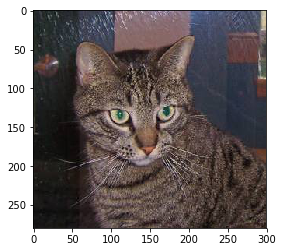

In [75]:
img=mpimg.imread('data/small_train/cat/cat.1.jpg')
imgplot = plt.imshow(img)
plt.show()

Change the numbers in the image name to look at a few other cats and get an overview of what we are working with. You will notice that not all cat images are perfect portraits. These images where scraped from the Internet, so some are of multiple cats or of cats in wired poses. Let's look at some dog images:

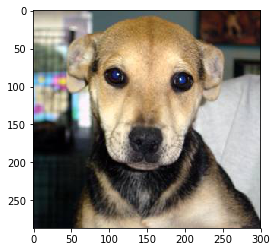

In [76]:
img=mpimg.imread('data/small_train/dog/dog.4.jpg')
imgplot = plt.imshow(img)
plt.show()

Again, try out a few different images to get a feel for what is going on. You will also notice that not all images are in the same format or have the same resolution.

## Setting up the neural net
To classify cats and dogs, we will use a convolutional neural network. It uses the ``Conv2D`` Keras layer we already discussed in the last chapter. Additionally it uses two new layers, ``MaxPool``and ``Flatten``.

## Maxpooling
Max pool pools a bunch of pixels together by just retaining the maximum value. This downsizes the image. A typical pooling window is 2 by to pixels, so it groups 4 pixels into one. For a pool window with activations like this:

||1|2|
|-|-|-|
|1|0.1|0.3|
|2|0.7|0.5|

Maxpool would return 0.7. Maxpool treats the different layers independently, so we will retain the number of layers and downsize the width and the height only. Maxpool as not trainable parameters itself.

## Flatten
The flatten layer turns the three dimensional convolutional blocks into one dimensional vectors that can be fed into a densely connected layer. This is done to transition from convolutional layers to dense ones.

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


We need to know the shape of our images. Images can be loaded 'channels first', meaning that in the representation of the shape the image the number of channels comes first. Otherwise, the images can be loaded 'channels last'. This is a setting in Keras. Usually it is best to just take what Keras chose by itself rather than tinkering with it so we will just request this setting:

In [5]:
# The keras backend module has information stored about how Keras wants to interact with its backend (TensorFlow)
from keras import backend as K

# We will resize all images to 150 by 150 pixels
img_width, img_height = 150, 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Now we get to the model itself:

In [6]:
model = Sequential()
# First conv layer:
# Filters: 32
# Kernel: 3x3 (9px)
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
# Max pool
# Size: 2x2 (combine 4px to 1)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
# Filters: 32
# Kernel: 3x3 (9px)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# Max pool
# Size: 2x2 (combine 4px to 1)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third conv layer
# Filters: 64
# Kernel: 3x3 (9px)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# Max pool
# Size: 2x2 (combine 4px to 1)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten turns 3D map into vector
model.add(Flatten())
# Dense layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

Note how we have implicitly rephrased our problem into a binary classification? We now discriminate cat, not cat. A not cat must then be a dog.

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

As you can see from the code above we have three convolutional layers. Each convolutional layer is followed by a maxpooling layer. You can see how maxpooling reduces the size of the image while not touching the number of layers. You can also see that the first densely connected layer has way more parameters than convolutional layers. This showx how effective ConvNets are, archieving great results while keeping the number of parameters low.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

## Setting up the data pipeline
In previous chapters, we have simply loaded all data into a numpy matrix and trained on that matrix. For images, this is not practical. A numpy matrix holding thousands of images would use a massive amount of memory. It makes much more sense to build a pipeline that supplies new images to the model as needed. The images get loaded from the hard drive, processed and then turned into numpy matrices that can get fed into the model. Keras has some built in tools that make this process easy. The data pipeline will look like this:

![Data flow](https://storage.googleapis.com/aibootcamp/Week%203/assets/dataflow.png)

### The data generator
The Keras [image data generator](https://keras.io/preprocessing/image/) takes images from files and turns them into tensor image data, which are very similar to numpy matrices holding the image. The image data generator can handle many different forms of pre processing. Here, we just want to look at some methods of image augumentation.

Image augumentation is the process of making random transformations to an image, like rotating it slightly or flipping it. Cropping the image or slightly stretching it is also very popular. This gives us multiple images out of one image, effectively increasing the amount of training data we have availeble by an order of magnitude. It leads to a more robust network that can recognize cats even if they look at the camera from a tilted angle.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40, # Rotate up to 40 degrees
        width_shift_range=0.2, # Shift width by max 20%
        height_shift_range=0.2, # Shift height by max 20%
        rescale=1./255, # Rescale pixel activations from 0 to 255 (as it is in files) to 0 to 1
        shear_range=0.2, # Cut away max 20% of the image
        zoom_range=0.2, # Zoom in 20% max
        horizontal_flip=True, # Flip image randomly
        fill_mode='nearest') # Fill missing pixels with the nearest value

Our data generator generates images from the cat image like this:

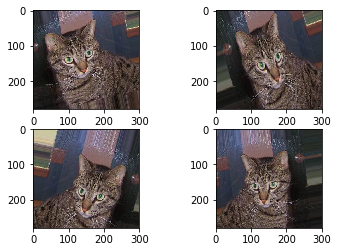

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(mpimg.imread('data/preview/cat_0_1.jpeg'))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mpimg.imread('data/preview/cat_0_2.jpeg'))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(mpimg.imread('data/preview/cat_0_3.jpeg'))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(mpimg.imread('data/preview/cat_0_4.jpeg'))

plt.show()

When testing the model we also want to use a data generator to get images into the model but we do not want to transform them. Thus we use a separate image generator for testing that only rescales the images:

In [18]:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

### Flow from directory
For classification to work with keras, the images have to be sorted into a certain folder structure. All images of one class have to be in the same folder. The class folders have to be in one folder which we then pass to the data flow function. The folder structure for our cats and dogs classification looks like this:
- /data
    - cat
        - cat.0.jpg
        - cat.1.jpg
        - cat.2.jpg
        - ...
    - dog
        - dog.0.jpg
        - dog.1.jpg
        - dog.2.jpg
        - ...

We set up our flow from directory for train and test set like this:

In [16]:
# Set up batch size
batch_size = 16
train_generator = datagen.flow_from_directory(
        'data/small_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size, # How many images do we need at a time
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [77]:
validation_generator = validation_datagen.flow_from_directory(
        'data/small_validation',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size, # How many images do we need at a time
        class_mode='binary')

Found 200 images belonging to 2 classes.


## Training the model
We will train the model we will validate it at the same time. After each epoch, we will do a validation run to make sure that our model generalizes well and does not overfit the training set. To train our model on data that is coming from generators, we use Keras [fit_generator](https://keras.io/models/sequential/) function. It works a little bit different than the fit function we have used before. The main difference is that we do not have to specify a batch size to the fit function since we have already specified to the flow from directory function above. Instead, we have to specify how many steps we want to take per epoch. Each step will do one forward and backward pass on one batch. 
A common setting for the steps per epoch is the integer rounded divison of the number of images and the batch size.

Training this model can take a while:

In [23]:
history = model.fit_generator(
        train_generator, # Get training data from training generator
        steps_per_epoch=2000 // batch_size, # // is the integer rounded division
        epochs=50, # train for 50 epochs
        validation_data=validation_generator, # Validate with validation generator
        validation_steps=200 // batch_size)

Epoch 1/50
125/125 [==============================] - 60s 477ms/step - loss: 0.6198 - acc: 0.6760 - val_loss: 0.6419 - val_acc: 0.5938
Epoch 2/50
125/125 [==============================] - 53s 426ms/step - loss: 0.6336 - acc: 0.6490 - val_loss: 0.6113 - val_acc: 0.6667
Epoch 3/50
125/125 [==============================] - 56s 446ms/step - loss: 0.6241 - acc: 0.6435 - val_loss: 0.6162 - val_acc: 0.6510
Epoch 4/50
125/125 [==============================] - 58s 466ms/step - loss: 0.6240 - acc: 0.6400 - val_loss: 0.6475 - val_acc: 0.5990
Epoch 5/50
125/125 [==============================] - 63s 506ms/step - loss: 0.6189 - acc: 0.6545 - val_loss: 0.6414 - val_acc: 0.5781
Epoch 6/50
125/125 [==============================] - 57s 453ms/step - loss: 0.6067 - acc: 0.6695 - val_loss: 0.5842 - val_acc: 0.6979
Epoch 7/50
125/125 [==============================] - 57s 455ms/step - loss: 0.6010 - acc: 0.6710 - val_loss: 0.6264 - val_acc: 0.6354
Epoch 8/50
125/125 [==============================] - 5

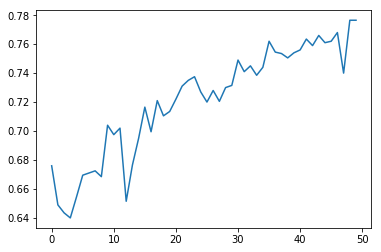

In [26]:
plt.plot(history.history['acc'])

After training, the model should archieve between 79% and 81%. At the time of the original Cats vs. Dogs competition in 2013, that would have been state of the art and you might have won the competition! You might have noted we have not used all 25000 images from the dataset but only 2000. We did this to save on disk space, download time and computational cost in this tutorial. With more images and training we probably could have done better. In the next chapter we will look at ways to archieve state of the art results.

## Using our cat classifier
Remember that our classifier is a binary classifier? This means it will output a single value between 0 and 1. We can see what a number means from our data generator, which also generates the labels:

In [54]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Zero means cat, one means dog. This means that the model should output values above 0.5 if a dog image is fed into it. We can feed a single image into the model like this:

In [63]:
# Load the whole image module
from keras.preprocessing import image
# Load numpy, how did we live without it so far??
import numpy as np
# Specify the file path
img_path = 'data/small_validation/dog/dog.1010.jpg'
# Load and resize the image
img = image.load_img(img_path, target_size=(150, 150))
# Turn the image into a numpy array
x = image.img_to_array(img)
# Resize the matrix to meet the expected shape
x = np.expand_dims(x, axis=0)
# Rescale the image
x = x / 255

# Obtain prediction
features = model.predict(x)
# Output prediction
print('Dog probability: ' + str(features))

Dog probability: [[ 0.98982388]]


This our model gives this image a high probability of being a dog. Let's render it:

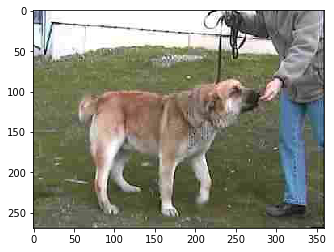

In [60]:
img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

And what a good boy it is! Let's loop over dog images to view some wrong predictions:

Actual: Dog, Predicted: Cat


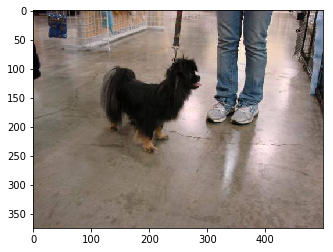

Actual: Dog, Predicted: Cat


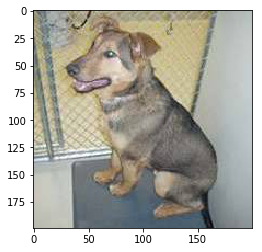

Actual: Dog, Predicted: Cat


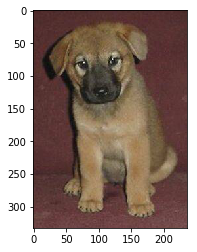

Actual: Dog, Predicted: Cat


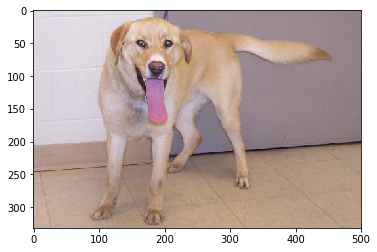

Actual: Dog, Predicted: Cat


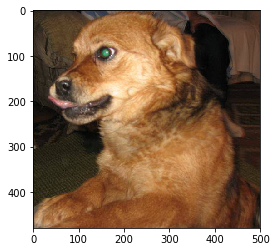

Actual: Dog, Predicted: Cat


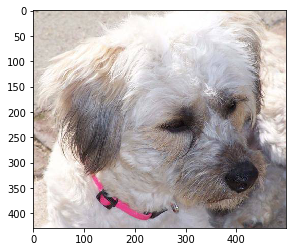

In [73]:
wrong_classifications = []
for i in range(1000,1100):
    img_path = 'data/small_validation/dog/dog.' +str(i)+ '.jpg'
    # Load and resize the image
    img = image.load_img(img_path, target_size=(150, 150))
    # Turn the image into a numpy array
    x = image.img_to_array(img)
    # Resize the matrix to meet the expected shape
    x = np.expand_dims(x, axis=0)
    # Rescale the image
    x = x / 255

    # Obtain prediction
    features = model.predict(x)
    if features < 0.5:
        wrong_classifications.append(img_path)
        print('Actual: Dog, Predicted: Cat')
        img=mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()
    if len(wrong_classifications) > 5:
        break

The images tend to be dogs in 'cat like' poses. Yet, many of these dogs are clearly recognizable as such. There still is a lot room for improvement. Let's look at some wrongly classified cats:

Actual: Cat, Predicted: Dog


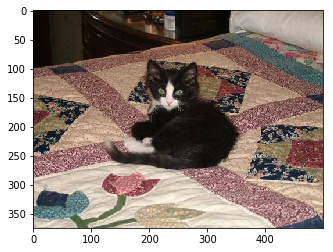

Actual: Cat, Predicted: Dog


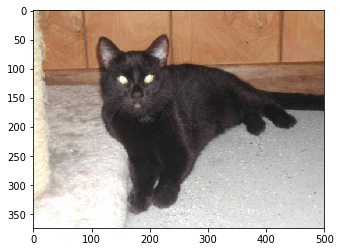

Actual: Cat, Predicted: Dog


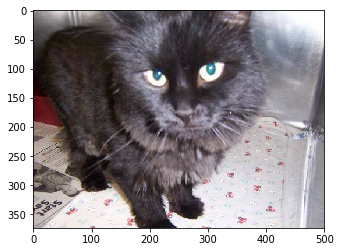

Actual: Cat, Predicted: Dog


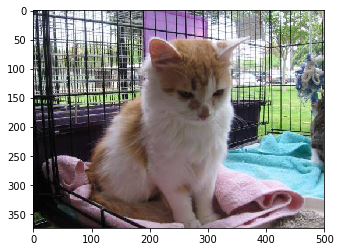

Actual: Cat, Predicted: Dog


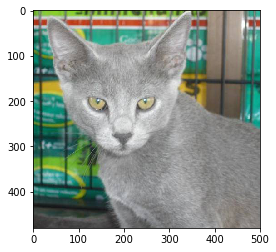

Actual: Cat, Predicted: Dog


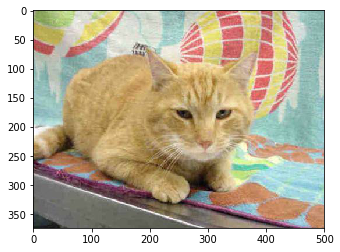

In [74]:
wrong_classifications = []
for i in range(1000,1100):
    img_path = 'data/small_validation/cat/cat.' +str(i)+ '.jpg'
    # Load and resize the image
    img = image.load_img(img_path, target_size=(150, 150))
    # Turn the image into a numpy array
    x = image.img_to_array(img)
    # Resize the matrix to meet the expected shape
    x = np.expand_dims(x, axis=0)
    # Rescale the image
    x = x / 255

    # Obtain prediction
    features = model.predict(x)
    if features > 0.5:
        wrong_classifications.append(img_path)
        print('Actual: Cat, Predicted: Dog')
        img=mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()
    if len(wrong_classifications) > 5:
        break

Again, a human has no problem telling these cats as cats. In the next chapter we will build a model that will do better. Never the less, the model we have built today is a decent baseline model to benchmark more advanced tools against. We should save the model:

In [47]:
model.save_weights('first_try.h5')

## Summary
In this chapter you have seen how to build a convolutional neural network in Keras and train it from scratch. You have learned about a few new techniques:
- Maxpool reduces the image size
- Flatten turns convolutional cubes into flat vectors
- Image data generators prepare images for training
- Flow from directory reads images from disks